# TiTiler-CMR: Tile Benchmarking

This notebook walks you through a workflow to **benchmark performance** of a [TiTiler-CMR](https://github.com/developmentseed/titiler-cmr) deployment for a given Earthdata CMR dataset.


> **What is TiTiler-CMR?**  
> [TiTiler](https://github.com/developmentseed/titiler) is a lightweight dynamic tiling server for raster/COG data. **TiTiler-CMR** is a variant/deployment that integrates with NASA's **Common Metadata Repository (CMR)** so you can render tiles **directly from CMR-managed datasets** (e.g., HDF5/NetCDF4/GRIB hosted on Earthdata Cloud). It can resolve a **CMR concept ID** to a renderable item, and expose tile and statistics endpoints without you needing to manually construct source URLs.
-----------------------------------
**In this notebook, you'll learn**:

- How to benchmark tile rendering performance across zoom levels
- What factors impact tile rendering performance in TiTiler-CMR for different backends (xarray vs rasterio)

In [94]:
import asyncio
import pandas as pd

from datacube_benchmark.titiler_cmr_benchmark import (
    DatasetParams,
    benchmark_viewport,
    benchmark_tileset,
    create_bbox_feature,
    tiling_benchmark_summary
)

## TiTiler-CMR Setup

`titiler-cmr` is a NASA-focused application that accepts Concept IDs and uses the Common Metadata Repository (CMR) to discover and serve associated granules as tiles. You can deploy your own instance of `titiler_cmr` using the [official guide](https://github.com/developmentseed/titiler-cmr), or use a public instance that is already deployed.

For this walkthrough, we will use the public instance hosted by [Open VEDA](https://staging.openveda.cloud/api/titiler-cmr/).

To get started with a dataset, you need to:
- Choose a Titiler-CMR endpoint
- Pick a CMR dataset (by concept ID)
- Identify the assets/variables/bands you want to visualize
- Define a temporal interval (`start/end` ISO range) and, if needed, a time step (e.g., daily).
- Select a backend that matches your dataset’s structure

Titiler-CMR supports two different backends:
  - **xarray** → for gridded/cloud-native datasets (e.g., NetCDF4/HDF5/GRIB), typically exposed as variables.
  - **rasterio** → for COG/raster imagery-style datasets exposed as bands (optionally via a regex).


> **Tip: Explore data granules with `earthaccess`**

>You can use [`earthaccess`](https://github.com/nsidc/earthaccess) to search and inspect the individual granules used in your query. This helps you validate which files were accessed, their sizes, and the temporal range.

```python
import earthaccess

concept_id = "C2723754864-GES_DISC"
time_range = ("2022-03-01T00:00:01Z", "2022-03-02T23:59:59Z")

# Authenticate if needed
earthaccess.login(strategy="netrc")  # or use "interactive" if needed

results = earthaccess.search_data(
    concept_id=concept_id,
    temporal=time_range
)

print(f"Found {len(results)} granules between {time_range[0]} and {time_range[1]}")
```


## Tile Generation Benchmarking
In this part, we are going to measure the tile generation performance across different zoom levels using `benchmark_viewport` function. 
This function simulates the load of a typical viewport render in a slippy map, where multiple adjacent tiles must be fetched in parallel to draw a single view.

Under the hood, `benchmark_viewport` computes the center tile for each zoom level, selects its neighboring tiles to approximate a viewport, and requests them concurrently from the TiTiler-CMR endpoint. This function returns a pandas DataFrame containing the response times for each tile request.



We want to also define the parameters for the CMR dataset we want to benchmark. The `DatasetParams` class encapsulates all the necessary information to interact with a specific dataset via TiTiler-CMR.


In [95]:
endpoint = "https://staging.openveda.cloud/api/titiler-cmr"

concept_id = "C2723754864-GES_DISC"
datetime_range="2022-03-01T00:00:01Z/2022-03-02T23:59:59Z"
variable="precipitation"

ds_xarray = DatasetParams(
            concept_id="C2723754864-GES_DISC",
            backend="xarray",
            datetime_range="2022-03-01T00:00:01Z/2022-03-01T23:59:59Z",
            variable="precipitation",
            step="P1D",
            temporal_mode="point",
        )



### Zoom Levels
Zoom levels determine the detail and extent of the area being rendered.  At lower zoom levels, a single tile covers a large spatial area and may intersect many granules. This usually translates to more I/O, more resampling/mosaic work, higher latency, and higher chance of timeouts or 5xx errors.
As you increase zoom, each tile covers a smaller area, reducing the number of intersecting granules and the amount of work per request. For many datasets, latency stabilizes around z≈9—that’s often a sensible “minimum viable zoom” for interactive experiences.

We'll define a range of zoom levels to test to see how performance varies.

In [58]:
min_zoom = 3
max_zoom = 20

# Define the viewport parameters
viewport_width = 2
viewport_height = 3
lng = 25.0
lat = 29.0

Now, let's run the benchmark across the specified zoom levels and visualize the results.

In [59]:

df_viewport = await benchmark_viewport(
    endpoint=endpoint,
    dataset=ds_xarray,
    lng=lng,
    lat=lat,
    viewport_width=viewport_width,
    viewport_height=viewport_height,
    min_zoom=min_zoom,
    max_zoom=max_zoom,
    timeout_s=60.0,
)


=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Query params: 8 parameters
  concept_id: C2723754864-GES_DISC
  backend: xarray
  datetime: 2022-03-01T00:00:01Z/2022-03-01T23:59:59Z
  variable: precipitation
  step: P1D
  temporal_mode: point
  tile_format: png
  tile_scale: 1
Zoom 3: 3x3 tiles (9 total)
Zoom 4: 3x3 tiles (9 total)
Zoom 5: 3x3 tiles (9 total)
Zoom 6: 3x3 tiles (9 total)
Zoom 7: 3x3 tiles (9 total)
Zoom 8: 3x3 tiles (9 total)
Zoom 9: 3x3 tiles (9 total)
Zoom 10: 3x3 tiles (9 total)
Zoom 11: 3x3 tiles (9 total)
Zoom 12: 3x3 tiles (9 total)
Zoom 13: 3x3 tiles (9 total)
Zoom 14: 3x3 tiles (9 total)
Zoom 15: 3x3 tiles (9 total)
Zoom 16: 3x3 tiles (9 total)
Zoom 17: 3x3 tiles (9 total)
Zoom 18: 3x3 tiles (9 total)
Zoom 19: 3x3 tiles (9 total)
Zoom 20: 3x3 tiles (9 total)


The output includes the following columns:
 
- `zoom, x, y` — XYZ tile indices
- `status_code` — HTTP code (200 = success, 204 = no-data, 4xx/5xx = errors)
- `response_time_sec` — wall time in seconds
- `response_size_bytes` — payload size
- `ok`, `is_error, has_data` — convenience flags

Now, let's use a convenience function to summarize the benchmark results. 

In [60]:
df_summary= tiling_benchmark_summary(df_viewport)
df_summary


,zoom,n_tiles,ok_pct,no_data_pct,error_pct,median_latency_s,p95_latency_s,median_size,median_rss_delta
0,3,9,100.0,0.0,0.0,2.377133,2.772662,694.00 B,0.00 B
1,4,9,100.0,0.0,0.0,2.248419,2.494313,694.00 B,0.00 B
2,5,9,100.0,0.0,0.0,3.322303,4.899871,694.00 B,0.00 B
3,6,9,100.0,0.0,0.0,5.153153,5.339714,694.00 B,0.00 B
4,7,9,100.0,0.0,0.0,5.543333,6.532397,694.00 B,0.00 B
5,8,9,100.0,0.0,0.0,6.996857,7.865935,694.00 B,0.00 B
6,9,9,100.0,0.0,0.0,9.284161,9.558531,694.00 B,0.00 B
7,10,9,100.0,0.0,0.0,8.934282,10.071211,694.00 B,0.00 B
8,11,9,100.0,0.0,0.0,10.171013,10.482466,694.00 B,0.00 B
9,12,9,100.0,0.0,0.0,10.614655,11.322454,694.00 B,0.00 B


In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

def summarize_and_plot_tiles_from_df(
    df: pd.DataFrame,
    *,
    jitter: float = 0.08,
    alpha: float = 0.35,
    figsize: tuple = (9, 5),
    title_lines: list[str] | None = None,
):
    """
    Build a summary & jitter plot (latency vs zoom) from an existing raw-results DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Raw tile results (e.g., from benchmark_viewport). Must contain at least:
        - zoom (or z)
        - response_time_sec (or elapsed_s)
        - ok, no_data
        - is_error (optional; inferred from status_code or ok/no_data if absent)
        - (optional) response_size_bytes/size_bytes, rss_delta for summary
    jitter : float
        Horizontal jitter to reduce overplotting.
    alpha : float
        Point transparency.
    figsize : tuple
        Figure size.
    title_lines : list[str] | None
        If provided, each string will be rendered on its own line as the plot title (left-aligned).
    silent_summary : bool
        If False, prints the summary; otherwise returns silently.

    Returns
    -------
    summary : pd.DataFrame
        Output of tiling_benchmark_summary(df, silent=True).
    (fig, ax) : tuple
        The matplotlib Figure and Axes.
    """
    if df is None or df.empty:
        raise ValueError("Empty DataFrame: no results to summarize/plot.")

    gdf = df.copy()
    # Check required columns
    required = {"zoom", "response_time_sec", "ok", "no_data"}
    missing = [c for c in required if c not in gdf.columns]
    if missing:
        raise KeyError(f"Expected columns missing after normalization: {missing}")

    # Infer is_error if not present
    if "is_error" not in gdf.columns:
        if "status_code" in gdf.columns:
            sc = pd.to_numeric(gdf["status_code"], errors="coerce")
            gdf["is_error"] = (sc >= 400) | sc.isna()
        else:
            gdf["is_error"] = ~(gdf["ok"].astype(bool) | gdf["no_data"].astype(bool))

    summary = tiling_benchmark_summary(gdf).copy()

    fig, ax = plt.subplots(figsize=figsize)
    fig.subplots_adjust(right=0.72, top=0.80)

    zoom_levels = sorted(int(z) for z in pd.to_numeric(gdf["zoom"], errors="coerce").dropna().unique())
    ax.set_xticks(zoom_levels)
    if zoom_levels:
        ax.set_xlim(min(zoom_levels) - 0.6, max(zoom_levels) + 0.6)

    for z in zoom_levels:
        sub = gdf[gdf["zoom"] == z]
        if sub.empty:
            continue

        x = np.random.normal(loc=z, scale=jitter, size=len(sub))
        ok_mask = sub["ok"].astype(bool).values
        err_mask = sub["is_error"].astype(bool).values  # already inferred above

        # 200 OK
        ax.scatter(
            x[ok_mask],
            sub.loc[ok_mask, "response_time_sec"],
            alpha=alpha,
            edgecolor="none",
            label=None,
        )
        # Errors (≥400 or failures)
        ax.scatter(
            x[err_mask],
            sub.loc[err_mask, "response_time_sec"],
            marker="x",
            alpha=min(0.85, alpha + 0.25),
            label=None,
        )

        # Median line per zoom
        med = pd.to_numeric(sub["response_time_sec"], errors="coerce").median()
        if np.isfinite(med):
            ax.hlines(med, z - 0.45, z + 0.45, linestyles="--")

    ax.set_xlabel("Zoom level")
    ax.set_ylabel("Tile response time (s)")

    # Legend proxies
    ok_proxy = Line2D([], [], linestyle="none", marker="o", label="200 OK")
    err_proxy = Line2D([], [], linestyle="none", marker="x", label="error (≥400 or failure)")
    ax.legend([ok_proxy, err_proxy], ["200 OK", "error"], frameon=False, loc="upper left", bbox_to_anchor=(1.02, 1.00))

    # Title block (optional)
    if title_lines:
        ax.set_title("\n".join(title_lines), fontsize=9, loc="left", pad=12)

    ax.grid(True, axis="y", alpha=0.2)
    plt.tight_layout()

    return summary, (fig, ax)

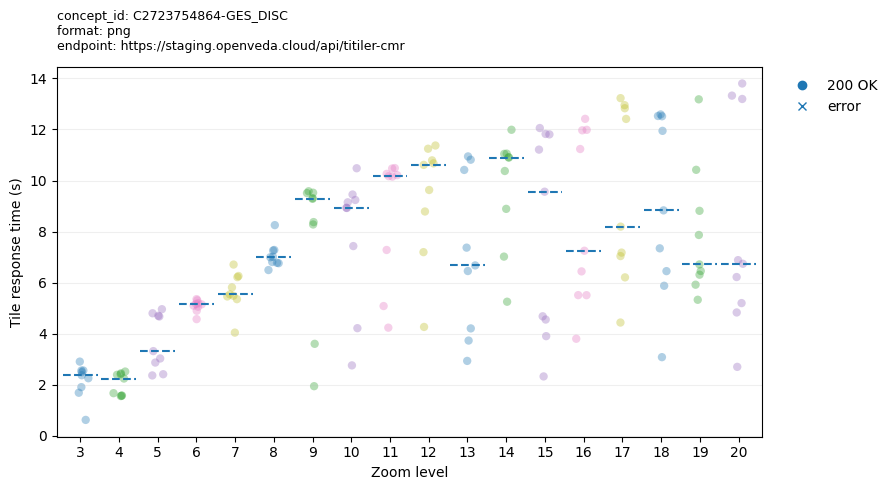

In [62]:
summary, (fig, ax) = summarize_and_plot_tiles_from_df(
    df_viewport,
    title_lines=[
        "concept_id: C2723754864-GES_DISC",
        "format: png",
        "endpoint: https://staging.openveda.cloud/api/titiler-cmr",
    ],
)

# Show summary table & plot
summary
plt.show()

### Rasterio Backend (COG/Band-based datasets)
In this example, we will benchmark a CMR dataset that is structured as Cloud Optimized GeoTIFFs (COGs) with individual bands. We will use the `rasterio` backend for this dataset.

In general, the lower the zoom level, the more files need to be opened to render a tile, which can lead to increased latency. Additionally, datasets with larger file sizes or more complex structures may also experience higher latency.

In Rasterio, each `/tile` request:
- finds all granules intersecting the tile footprint and the selected datetime interval,
- reads & mosaics them (across space/time), resamples, stacks bands, then encodes the image  

In contrast to the xarray backend, the rasterio backend’s tile latency depends strongly on the width of the datetime interval.

In [127]:
ds_hls_day = DatasetParams(
    concept_id="C2021957657-LPCLOUD",
    backend="rasterio",
    datetime_range="2023-10-01T00:00:01Z/2023-10-07T00:00:01Z",
    bands=["B04", "B03", "B02"],
    bands_regex="B[0-9][0-9]",
    step="P1D",
    temporal_mode="point",
)
ds_hls_week = DatasetParams(
    concept_id="C2021957657-LPCLOUD",
    backend="rasterio",
    datetime_range="2023-10-01T00:00:01Z/2023-10-20T00:00:01Z",
    bands=["B04", "B03", "B02"],
    bands_regex="B[0-9][0-9]",
    step="P1W",
    temporal_mode="point",
)

min_zoom = 17
max_zoom = 20
viewport_width = 3
viewport_height = 3
timeout_s = 60.0

In [128]:
df_viewport_day = await benchmark_viewport(
            endpoint=endpoint,
            dataset=ds_hls_day,
            lng=lng,
            lat=lat,
            viewport_width=viewport_width,
            viewport_height=viewport_height,
            min_zoom=min_zoom,
            max_zoom=max_zoom,
            timeout_s=timeout_s,
        )

df_viewport_day_summary= tiling_benchmark_summary(df_viewport_day)
df_viewport_day_summary

=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2021957657-LPCLOUD (rasterio)
Query params: 11 parameters
  concept_id: C2021957657-LPCLOUD
  backend: rasterio
  datetime: 2023-10-01T00:00:01Z/2023-10-07T00:00:01Z
  bands: B04
  bands: B03
  bands: B02
  bands_regex: B[0-9][0-9]
  step: P1D
  temporal_mode: point
  tile_format: png
  tile_scale: 1
Zoom 17: 3x3 tiles (9 total)
Zoom 18: 3x3 tiles (9 total)
Zoom 19: 3x3 tiles (9 total)
Zoom 20: 3x3 tiles (9 total)


,zoom,n_tiles,ok_pct,no_data_pct,error_pct,median_latency_s,p95_latency_s,median_size,median_rss_delta
0,17,9,100.0,0.0,0.0,6.234153,8.763287,1017.00 B,0.00 B
1,18,9,100.0,0.0,0.0,8.743939,10.794708,834.00 B,0.00 B
2,19,9,100.0,0.0,0.0,7.130048,11.715817,771.00 B,0.00 B
3,20,9,100.0,0.0,0.0,7.271104,10.104547,734.00 B,0.00 B


In [130]:
df_viewport_week = await benchmark_viewport(
            endpoint=endpoint,
            dataset=ds_hls_week,
            lng=lng,
            lat=lat,
            viewport_width=viewport_width,
            viewport_height=viewport_height,
            min_zoom=min_zoom,
            max_zoom=max_zoom,
            timeout_s=timeout_s,
        )

df_viewport_week_summary= tiling_benchmark_summary(df_viewport_week)
df_viewport_week_summary

=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2021957657-LPCLOUD (rasterio)
Query params: 11 parameters
  concept_id: C2021957657-LPCLOUD
  backend: rasterio
  datetime: 2023-10-01T00:00:01Z/2023-10-20T00:00:01Z
  bands: B04
  bands: B03
  bands: B02
  bands_regex: B[0-9][0-9]
  step: P1W
  temporal_mode: point
  tile_format: png
  tile_scale: 1
Zoom 17: 3x3 tiles (9 total)
Zoom 18: 3x3 tiles (9 total)
Zoom 19: 3x3 tiles (9 total)
Zoom 20: 3x3 tiles (9 total)


,zoom,n_tiles,ok_pct,no_data_pct,error_pct,median_latency_s,p95_latency_s,median_size,median_rss_delta
0,17,9,100.0,0.0,0.0,7.837916,9.912259,1017.00 B,0.00 B
1,18,9,100.0,0.0,0.0,7.984491,12.737423,834.00 B,0.00 B
2,19,9,100.0,0.0,0.0,11.092206,11.514204,771.00 B,0.00 B
3,20,9,100.0,0.0,0.0,11.693765,13.195988,734.00 B,0.00 B


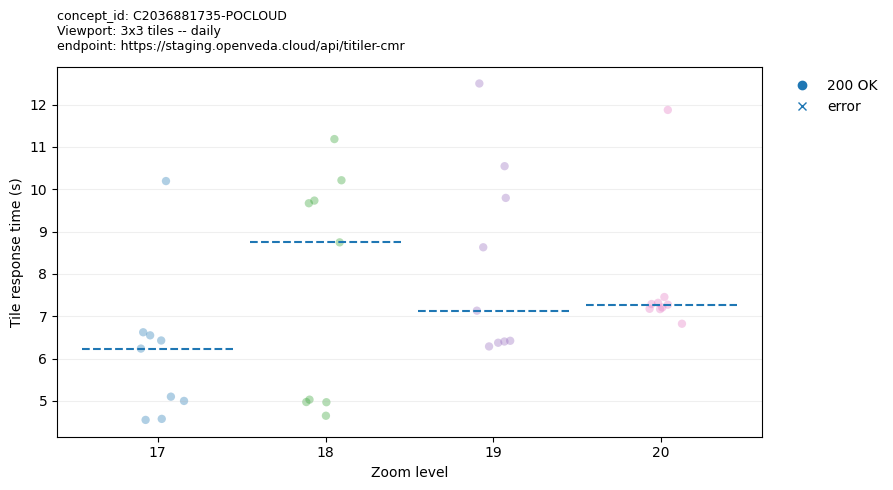

In [131]:
summary, (fig, ax) = summarize_and_plot_tiles_from_df(
    df_viewport_day,
    title_lines=[
        "concept_id: C2036881735-POCLOUD",
        "Viewport: 3x3 tiles -- daily",
        "endpoint: https://staging.openveda.cloud/api/titiler-cmr",
    ],
)

plt.show()

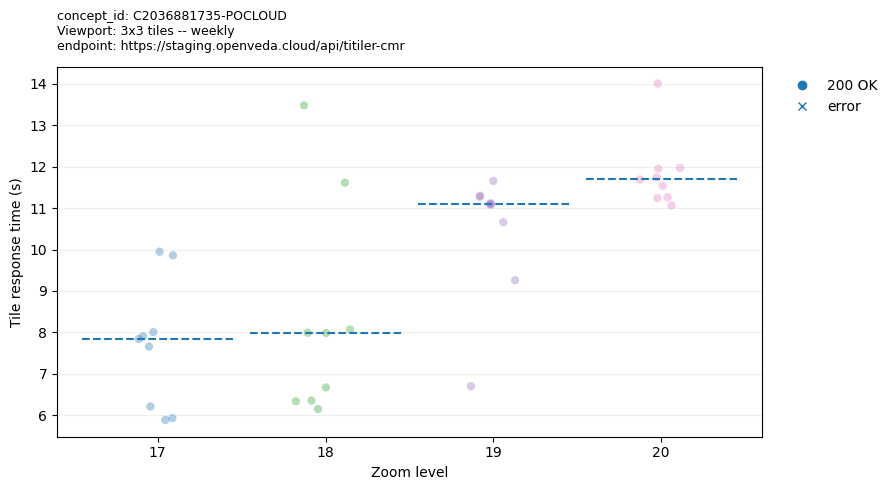

In [132]:
summary, (fig, ax) = summarize_and_plot_tiles_from_df(
    df_viewport_week,
    title_lines=[
        "concept_id: C2036881735-POCLOUD",
        "Viewport: 3x3 tiles -- weekly",
        "endpoint: https://staging.openveda.cloud/api/titiler-cmr",
    ],
)

plt.show()

You can also run a similar check on a subset of data that has been defined by `tiling.create_bbox_feature`

In [ ]:
ds_xarray = DatasetParams.for_xarray(
    concept_id="C2723754864-GES_DISC",
    datetime_range="2022-03-01T00:00:01Z/2022-03-02T23:59:59Z",
    variable="precipitation",
    step="P1D",
    temporal_mode="point"
    )
small_area = create_bbox_feature(-95.0, 28.0, -94.0, 29.0)


=== TiTiler-CMR Compatibility Check ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Query params: 6 parameters
  concept_id: C2723754864-GES_DISC
  backend: xarray
  datetime: 2022-03-01T00:00:01Z/2022-03-02T23:59:59Z
  variable: precipitation
  step: P1D
  temporal_mode: point
Found 2 timesteps/granules from TileJson!
Statistics request failed: RuntimeError: Cannot send a request, as the client has been closed.
Compatibility: issues_detected
Timesteps: 2
Bounds: [-180.0, -90.0, 180.0, 90.0]


## Tiling Benchmark Over a custom bounds region

In this part, we are going to measure response latency across the tiles at different zoom levels using `benchmark_titiler_cmr` function. 
This function simulates the load of a typical viewport render in a slippy map, where multiple adjacent tiles must be fetched in parallel to draw a single view.

Under the hood, `benchmark_titiler_cmr` computes the center tile for each zoom level, selects its neighboring tiles to approximate a viewport, and requests them concurrently from the TiTiler-CMR endpoint. This function returns a pandas DataFrame containing the response times for each tile request.

In [ ]:
df_viewport = await benchmark_viewport(
    endpoint=endpoint,
    dataset=ds_xarray,
    lng=-95.0,
    lat=29.0,
    viewport_width=3,
    viewport_height=3,
    min_zoom=7,
    max_zoom=8,
    timeout_s=60.0,
)

df_viewport.head()



=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Query params: 8 parameters
  concept_id: C2723754864-GES_DISC
  backend: xarray
  datetime: 2022-03-01T00:00:01Z/2022-03-02T23:59:59Z
  variable: precipitation
  step: P1D
  temporal_mode: point
  tile_format: png
  tile_scale: 1
Found 2 timesteps from TileJson.
Zoom 7: 3x3 tiles (9 total)
Zoom 8: 3x3 tiles (9 total)


,z,x,y,timestep_index,url,response,status_code,elapsed_s,size_bytes,content_type,ok,no_data,error_text,rss_delta
0,7,29,52,0,https://staging.openveda.cloud/api/titiler-cmr...,<Response [200 OK]>,200,1.071505,694,image/png,True,False,None,270336
1,7,29,52,1,https://staging.openveda.cloud/api/titiler-cmr...,<Response [200 OK]>,200,0.887765,694,image/png,True,False,None,0
2,7,30,52,0,https://staging.openveda.cloud/api/titiler-cmr...,<Response [200 OK]>,200,0.771767,694,image/png,True,False,None,270336
3,7,30,52,1,https://staging.openveda.cloud/api/titiler-cmr...,<Response [200 OK]>,200,0.724302,694,image/png,True,False,None,0
4,7,31,52,0,https://staging.openveda.cloud/api/titiler-cmr...,<Response [200 OK]>,200,0.790623,694,image/png,True,False,None,270336


#### Band Combinations

In Rasterio backend, you can specify multiple bands to be rendered in a single tile request. This is useful for visualizing different aspects of the data, such as true color composites or vegetation indices.

More bands typically mean larger payloads and potentially higher latency, especially if the bands are stored in separate files. 

In [122]:
# Configure zooms and interval
min_zoom = 5
max_zoom = 15
zoom_levels = list(range(min_zoom, max_zoom + 1))

start = "2023-01-01T00:00:00Z"
end   = "2023-01-07T23:59:59Z"

# Band sets to compare
asset_sets = {
    "1 band": ["B04"],
    "2 bands": ["B04", "B03"],
    "3 bands": ["B04", "B03", "B02"],
}

tasks = []
labels = []

for label, assets in asset_sets.items():
    # DatasetParams now uses top-level args (no for_rasterio factory)
    ds = DatasetParams(
        concept_id=concept_id,
        backend="rasterio",
        datetime_range=f"{start}/{end}",
        bands=assets,
        bands_regex="B[0-9][0-9]",
    )

    # benchmark_viewport now takes an explicit list of zoom_levels
    tasks.append(
        benchmark_viewport(
            endpoint=endpoint,
            dataset=ds,
            lng=lng,
            lat=lat,
            min_zoom=min_zoom,
            max_zoom=max_zoom,
            viewport_width=3,
            viewport_height=3,
            timeout_s=timeout_s,
        )
    )
    labels.append(label)

# Run all benchmarks concurrently
dfs = await asyncio.gather(*tasks)
print (dfs)
# Build a panel of median latency by zoom for each band set
median_by_zoom = []
for df in dfs:
    # New schema: 'zoom' and 'response_time_sec'
    s = (
        df.groupby("zoom")["response_time_sec"]
          .median()
          .reindex(zoom_levels)
    )
    median_by_zoom.append(s)

panel_df = pd.concat(median_by_zoom, axis=1)
panel_df.columns = labels
panel_df


=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (rasterio)
Query params: 7 parameters
  concept_id: C2723754864-GES_DISC
  backend: rasterio
  datetime: 2023-01-01T00:00:00Z/2023-01-07T23:59:59Z
  bands: B04
  bands_regex: B[0-9][0-9]
  tile_format: png
  tile_scale: 1
=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (rasterio)
Query params: 8 parameters
  concept_id: C2723754864-GES_DISC
  backend: rasterio
  datetime: 2023-01-01T00:00:00Z/2023-01-07T23:59:59Z
  bands: B04
  bands: B03
  bands_regex: B[0-9][0-9]
  tile_format: png
  tile_scale: 1
=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (rasterio)
Query params: 9 parameters
  concept_id: C2723754864-GES_DISC
  backend: rasterio
  datetime: 2023-01-01T00:00:00Z/2023-01-07T23:59:59Z
  bands: B04
  bands: B03
  bands: B02


,1 band,2 bands,3 bands
zoom,,,
5,2.787367,2.809602,3.166915
6,3.342133,2.891093,2.829793
7,3.803739,4.109565,4.064350
8,4.451749,4.492469,4.529533
9,4.731278,5.068691,4.442746
10,5.404782,5.508743,5.088867
11,5.702274,5.628592,5.551665
12,5.818986,5.786629,5.990249
13,6.046866,5.412840,6.041488


In [125]:
dfs

[    zoom      x      y                                                url  \
 0      5     17     12  https://staging.openveda.cloud/api/titiler-cmr...   
 1      5     18     12  https://staging.openveda.cloud/api/titiler-cmr...   
 2      5     19     12  https://staging.openveda.cloud/api/titiler-cmr...   
 3      5     17     13  https://staging.openveda.cloud/api/titiler-cmr...   
 4      5     18     13  https://staging.openveda.cloud/api/titiler-cmr...   
 ..   ...    ...    ...                                                ...   
 94    15  18659  13623  https://staging.openveda.cloud/api/titiler-cmr...   
 95    15  18660  13623  https://staging.openveda.cloud/api/titiler-cmr...   
 96    15  18658  13624  https://staging.openveda.cloud/api/titiler-cmr...   
 97    15  18659  13624  https://staging.openveda.cloud/api/titiler-cmr...   
 98    15  18660  13624  https://staging.openveda.cloud/api/titiler-cmr...   
 
     status_code  response_time_sec  response_size_bytes      

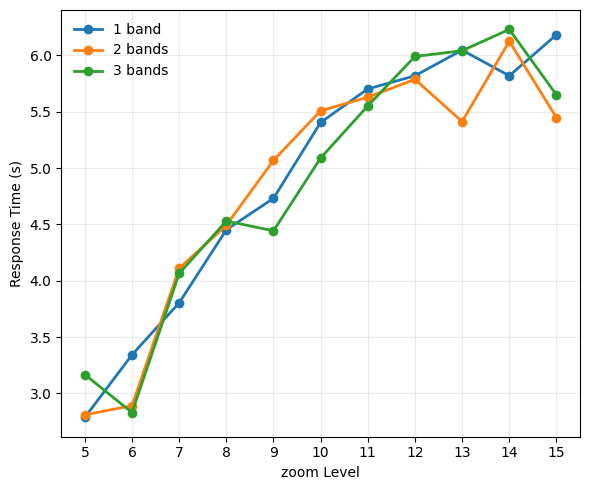

In [126]:
# --- plot all three lines together ---
fig, ax = plt.subplots(figsize=(6, 5))
for col in panel_df.columns:
    ax.plot(zoom_levels, panel_df[col].values, marker="o", linewidth=2, label=col)

ax.set_xticks(zoom_levels)             # exact zoom values
ax.set_xlabel("zoom Level")
ax.set_ylabel("Response Time (s)")
ax.grid(True, alpha=0.25)

# legend outside on the right
fig.subplots_adjust(right=0.78)
ax.legend(frameon=False, loc="best")

# optional title (set your collection name if you like)

plt.tight_layout()
plt.show()


## Conclusion

In this notebook, we explored how to benchmark tile rendering performance in TiTiler-CMR using different datasets and backends. We observed how factors such as zoom levels, temporal intervals, and dataset structures impact the latency of tile requests.

In general, Xarray backend:
- Performance depends strongly on the zoom levels, 
- Reads a single timestep for `/tile` requests so interval width generally does not change tile latency.

In Raterio backend:
- Covers all the granules intersecting the tile footprint and the selected datetime interval,
- Performance depends on zoom levels and the width of the datetime interval, and band selection
- Higher zoom levels (e.g., z > 9) tend to have more stable and lower latency due to fewer intersecting granules. However, performance plateaus around z≈9 for many datasets.


Take aways: 
- Prefer **single-day** (or narrow) intervals for responsive rendering
- The bigger the time range, the more data needs to be scanned and processed
- Avoid very low zooms for heavy composites; consider **minzoom ≥ 7**


### Further Reading
- [TiTiler-CMR GitHub Repository](https://github.com/cogeotiff/titiler-cmr)
- [Titiler-CMR API Documentation](https://staging.openveda.cloud/api/titiler-cmr/api.html#/)
- [Tile Matrix Sets and Zoom Levels](https://docs.opengeospatial.org/is/17-083r2/17-083r2.html#_tile_matrix_sets_and_zoom_levels)
- [Earthdata Cloud CMR Datasets](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#datasets)
